In [1]:
import time
import json

import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

import run

v_sets, e_sets, core_targets, ext_targets, v_sample, e_sample = run.main()

Running the scripts sequentially 

LOADING DATA: 134.61 s
SUBSAMPLING: 0.06 s
PREPROCESSING: Complete in 0.05 s


In [3]:
batch_size = 200
epochs = 20
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

In [4]:
# Initialize SG graph
G = sg.StellarDiGraph(v_sets, e_sets)

In [5]:
nodes_with_labels = v_sets.copy()

In [6]:
ext_targets.size

2765

In [7]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 18996, Edges: 10000

 Node types:
  Account: [11051]
    Features: float32 vector, length 3
    Edge types: Account-money transfer->Account, Account-money transfer->Derived Entity
  Customer: [3345]
    Features: float32 vector, length 5
    Edge types: Customer-has account->Account, Customer-has address->Address, Customer-is similar->External Entity
  Derived Entity: [3010]
    Features: float32 vector, length 4
    Edge types: Derived Entity-is similar->External Entity, Derived Entity-money transfer->Account
  External Entity: [1169]
    Features: float32 vector, length 4
    Edge types: none
  Address: [421]
    Features: float32 vector, length 2
    Edge types: none

 Edge types:
    Account-money transfer->Account: [3326]
        Weights: range=[1, 500], mean=178.224, std=222.553
        Features: none
    Customer-has account->Account: [2915]
        Weights: all 1 (default)
        Features: none
    Derived Entity-money transfer->Acco

In [8]:
# Split edges into train and test sets

train_ID, test_ID = model_selection.train_test_split(
    ext_targets, train_size=train_size, test_size=test_size, #stratify=ext_targets
)

In [9]:
# Select only nodes of type "Account" for prediction

train_ID = train_ID[train_ID.index.isin(v_sets['Account'].index)]
test_ID = test_ID[test_ID.index.isin(v_sets['Account'].index)]

In [10]:
# Convert targets labels in one-hot encoded features (optional, for categorical targets)

target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_ID)
test_targets = target_encoding.transform(test_ID)

In [11]:
train_ID.shape

(912, 1)

In [12]:
train_targets.shape

(912, 695)

In [13]:
# Choosing a 2 layer model with 8 nodes sampled in the first layer and 4 in the second.
num_samples = [8, 4]
# we can do 8*4 = 32x32 hidden layer size, since len(num_samples) defines 
# the number of hops (layers) in the HinSAGE model

In [14]:
'''
HinSAGENodeGenerator(G, batch_size, num_samples, head_node_type=None, schema=None, seed=None, name=None)

G = graph
batch_size = size of batch to return
num_samples = the number of samples per layer (hop) to take
head_node_type = the node type that will be given to the generator using the flow method. 
                  The model will expect this type.
                  If not given, it defaults to a single node type.
'''

generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

In [15]:
# Flow

train_gen = generator.flow(train_ID.index, train_targets, shuffle=True)
test_gen = generator.flow(test_ID.index, test_targets)

In [16]:
generator.schema.schema

{'Address': [],
 'Account': [EdgeType(n1='Account', rel='money transfer', n2='Account'),
  EdgeType(n1='Account', rel='money transfer', n2='Derived Entity')],
 'External Entity': [],
 'Derived Entity': [EdgeType(n1='Derived Entity', rel='is similar', n2='External Entity'),
  EdgeType(n1='Derived Entity', rel='money transfer', n2='Account')],
 'Customer': [EdgeType(n1='Customer', rel='has account', n2='Account'),
  EdgeType(n1='Customer', rel='has address', n2='Address'),
  EdgeType(n1='Customer', rel='is similar', n2='External Entity')]}

In [17]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

In [18]:
# Dropout
# (must be tuned)

dropout = 0.0

In [19]:
hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    #activations=['relu', 'softmax'],
    generator=generator, 
    bias=True, 
    dropout=dropout
)

In [39]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=15)

In [46]:
def run_deep_graph_infomax(base_model, generator, epochs):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="Account"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])
    
    sg.utils.plot_history(history)

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    # for full batch models, squeeze out the batch dim (which is 1)
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    #do TSNE here
    return x_emb_in, x_emb_out


In [92]:
# TO TEST:
def run_classify(x_emb_in, x_emb_out, train_ID, test_ID):
    #train_subjects, test_subjects = model_selection.train_test_split(
    #    subjects, train_size=0.1, test_size=None)
    
    train_subjects = train_ID
    test_subjects = test_ID
    
    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

    test_gen = generator.flow(test_subjects.index)
    train_gen = generator.flow(train_subjects.index)

    test_embeddings = emb_model.predict(test_gen)
    train_embeddings = emb_model.predict(train_gen)

    # some generators yield predictions in a different order to the .flow argument,
    # so we need to get everything lined up correctly
    #ordered_test_subjects = reorder(test_gen, test_subjects)
    #ordered_train_subjects = reorder(train_gen, train_subjects)

    lr = LogisticRegression(multi_class="auto", solver="lbfgs")
    lr.fit(train_embeddings, ordered_train_subjects)

    y_pred = lr.predict(test_embeddings)
    acc = (y_pred == ordered_test_subjects).mean()

    return acc, x_emb_out

Epoch 1/20
56/56 [==============================] - 6s 114ms/step - loss: 0.3328
Epoch 2/20
56/56 [==============================] - 6s 113ms/step - loss: 0.1520
Epoch 3/20
56/56 [==============================] - 6s 111ms/step - loss: 0.1151
Epoch 4/20
56/56 [==============================] - 6s 115ms/step - loss: 0.0998
Epoch 5/20
56/56 [==============================] - 6s 114ms/step - loss: 0.0964
Epoch 6/20
56/56 [==============================] - 7s 117ms/step - loss: 0.0936
Epoch 7/20
56/56 [==============================] - 6s 115ms/step - loss: 0.0884
Epoch 8/20
56/56 [==============================] - 7s 116ms/step - loss: 0.0953
Epoch 9/20
56/56 [==============================] - 6s 112ms/step - loss: 0.0938
Epoch 10/20
56/56 [==============================] - 6s 111ms/step - loss: 0.0844
Epoch 11/20
56/56 [==============================] - 6s 116ms/step - loss: 0.0837
Epoch 12/20
56/56 [==============================] - 7s 117ms/step - loss: 0.0903
Epoch 13/20
56/56 [======

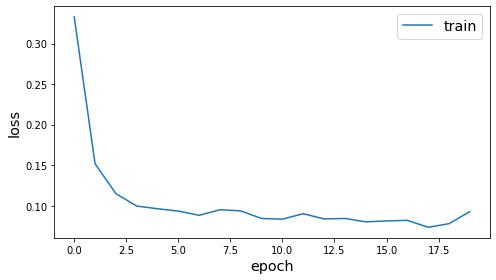

In [48]:
# Deep Graph Infomax

x_emb_in, x_emb_out = run_deep_graph_infomax(hinsage, generator, epochs=epochs)

In [88]:
## TO FIX::
# FullBatchNodeGenerator doesn't like heterogeneous graphs
# maybe switch to another generator
# Or change technique for doing TSNE?

emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)

all_embeddings = emb_model.predict(fullbatch_generator.flow(G.nodes(node_type="Account")))
y = ext_targets.astype("category")
trans = TSNE(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=G.nodes(node_type="Account"))
emb_transformed['label'] = y

ValueError: G: expected a graph with a single node type, found a graph with node types: 'Account', 'Address', 'Customer', 'Derived Entity', 'External Entity'

NameError: name 'emb_transformed' is not defined

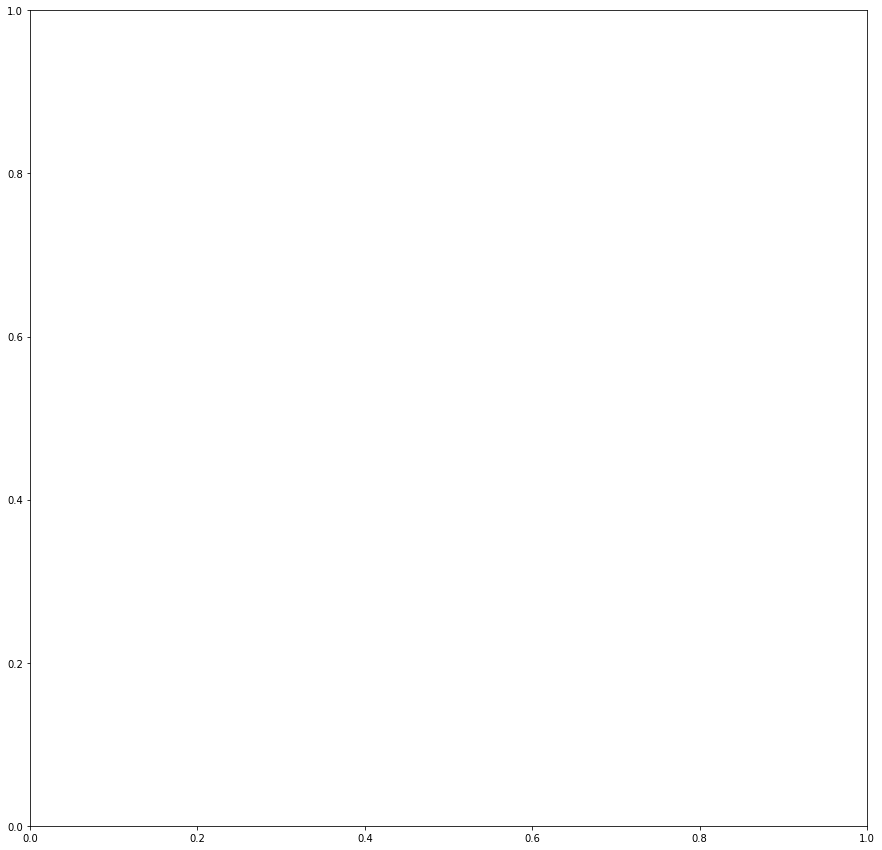

In [93]:
alpha = 0.7
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].cat.codes,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("TSNE visualization of GCN embeddings for dataset")
plt.show()